In [1]:
import kooplearn
import kooplearn.datasets
import matplotlib.pyplot as plt


In [2]:
import logging
import math
from pathlib import Path
from typing import Optional

import numpy as np
import scipy
import scipy.sparse
from scipy.integrate import romb
from scipy.special import binom
from scipy.stats.sampling import NumericalInversePolynomial

from kooplearn._src.utils import topk
from kooplearn.datasets.misc import (
    DataGenerator,
    DiscreteTimeDynamics,
    LinalgDecomposition,
)

from kooplearn.datasets.stochastic import LangevinTripleWell1D


In [9]:
CDF_SAMPLES = 2**10 + 1  # Should be a power of 2 + 1 for Romberg integration
def _check_cdf(arr):
    if np.ndim(arr) < 1:
        arr = np.atleast_1d(arr)
    elif np.ndim(arr) > 1:
        raise ValueError()
    return arr

def CRPS_discrete(observation, cdf_centers, cdf_weights):
    # Continuous ranked probability score
    cdf_centers = _check_cdf(cdf_centers)
    cdf_weights = _check_cdf(cdf_weights)

    # Add breakpoint at 'observation'
    cdf_centers = np.append(cdf_centers, [observation])
    cdf_weights = np.append(cdf_weights, [-1])

    # Sort centers
    sort_perm = np.argsort(cdf_centers)
    cdf_centers = cdf_centers[sort_perm]
    cdf_weights = cdf_weights[sort_perm]
    cdf_difference = np.cumsum(cdf_weights)[:-1]
    return np.sum(np.diff(cdf_centers) * (cdf_difference**2))


def CRPS_continuous(observation, cdf, samples):
    cdf = _check_cdf(cdf)
    samples = _check_cdf(samples)

    sort_perm = np.argsort(samples)
    samples = samples[sort_perm]
    cdf = cdf[sort_perm]

    cdf_difference = np.where(observation - samples >= 0, cdf, 1 - cdf)
    dx = samples[1] - samples[0]
    return romb(cdf_difference**2, dx=dx)


# Models
def mean_baseline(train_data, test_data):
    # The model here is just the mean of the training sample
    mean_baseline = np.mean(train_data)

    cdf_centers = mean_baseline
    cdf_weights = 1

    _crps = [
        CRPS_discrete(observation, cdf_centers, cdf_weights)
        for observation in test_data
    ]

    report = {
        "CRPS": np.asanyarray(_crps),
        "mean": mean_baseline * np.ones_like(test_data),
    }
    return report





def CIR_model(train_data, test_data):
    y = np.diff(train_data) / np.sqrt(np.abs(train_data[:-1]))
    z2 = np.sqrt(np.abs(train_data[:-1]))
    z1 = z2**-1
    z = np.stack([z1, z2]).T

    beta, res, _, _ = lstsq(z, y)

    mean_reversion_rate = -beta[1]  # \theta
    mean_interest_rate = beta[0] / mean_reversion_rate  # \mu
    scale = np.sqrt(res / (len(train_data) - 2))  # \sigma

    print(
        f"[CIR] Reversion timescale {mean_reversion_rate**-1:.1f} weeks - Mean interest: {mean_interest_rate:.2f}%"
    )

    cdf_grid = np.linspace(1e-1, test_data.max() + 3, CDF_SAMPLES)
    crps_metric = []
    mean_metric = []
    cdfs =[]
    for obs_idx, observation in enumerate(test_data):
        centers, cdf, m = CIR_cdf(
            cdf_grid,
            train_data[-1],
            mean_interest_rate,
            mean_reversion_rate,
            scale,
            obs_idx + 1,
        )

        crps_metric.append(CRPS_continuous(observation, cdf, centers))
        mean_metric.append(m)
        cdfs.append(cdf)

    report = {
        "CRPS": np.asanyarray(crps_metric),
        "mean": np.asanyarray(mean_metric),
    }
    return report,cdfs, cdf_grid


def CIR_cdf(grid, x_init, mu, theta, sigma, t):
    from scipy.stats import ncx2

    # a = theta; b = mu
    c = 2 * theta / ((1 - np.exp(-theta * t)) * (sigma**2))

    df = 4 * theta * mu / (sigma**2)  # Degrees of fredoom
    nc = 2 * c * x_init * np.exp(-theta * t)  # Non-centrality

    mean = x_init * np.exp(-theta * t) + mu * (1 - np.exp(-theta * t))
    return grid, ncx2.cdf(grid * 2 * c, df, nc), mean





def load_data(
    start_date="2009-01-01", end_train_date="2016-12-31", end_test_date="2018-12-31"
):
    data_path = "data/mortgage/MORTGAGE30US.csv"
    df = pd.read_csv(str(data_path))
    df["DATE"] = pd.to_datetime(df["DATE"])

    start_date = pd.to_datetime(start_date)
    end_train_date = pd.to_datetime(end_train_date)
    end_date = pd.to_datetime(end_test_date)
    # Train-test splitting
    df_train = df[(df["DATE"] >= start_date) & (df["DATE"] <= end_train_date)]
    df_test = df[(df["DATE"] > end_train_date) & (df["DATE"] <= end_date)]

    train_data = df_train["MORTGAGE30US"].values
    test_data = df_test["MORTGAGE30US"].values
    print(f"Train: {train_data.shape[0]}\tTest: {test_data.shape[0]}")
    return train_data, test_data, df_train, df_test




In [10]:
from sklearn.gaussian_process.kernels import RBF
from kooplearn.data import traj_to_contexts
from kooplearn._src.linalg import _rank_reveal, modified_QR, weighted_norm
from kooplearn._src.utils import fuzzy_parse_complex, topk
from kooplearn._src.operator_regression.dual import estimator_eig
import tqdm
from scipy.linalg import lstsq

def return_M(kernel,X, friction,k_X):

    sigma = kernel.length_scale
        
    X = X.reshape(X.shape[0],-1)

    difference = (X[:, np.newaxis, :] - X[np.newaxis, :, :])

    n =  difference.shape[2]
    dphi = (1/sigma**2 -difference[:,:,0]**2  / sigma**4  )* k_X     
    return np.einsum("i,j,ij->ij",friction, friction, dphi)

def return_N(kernel, X, friction, k_X):
    sigma = kernel.length_scale    
    X = X.reshape(X.shape[0],-1)
    difference = (X[:, np.newaxis, :] - X[np.newaxis, :, :])
    n =  difference.shape[2]
    dphi =  difference[:,:,0] * k_X / sigma**2     

    return np.einsum("j,ij->ij",friction,dphi)#np.sqrt(friction) * dphi


def rrr_UV17(k_X, N, M, eta, gamma, r):
    L = np.block([[k_X/eta, np.zeros(k_X.shape)],[np.zeros(k_X.shape),np.zeros(k_X.shape)]])
    n= k_X.shape[0]
    k_gamma = k_X + gamma * np.eye(n)
    J= k_X - N@np.linalg.inv(M+gamma*eta*np.eye(n))@N.T

    sigmas_2, vectors = scipy.sparse.linalg.eigs(J@k_X, k=r+5,M=(J+gamma*np.eye(n))*eta)
    indices = np.argsort(sigmas_2.real)[-r:]

    V_global = vectors[:,indices]
    V_global =V_global@ np.diag(1/np.sqrt(np.diag(V_global.T @ k_X @V_global)))
    sigma = np.diag(sigmas_2[indices])


    make_U = np.block([np.eye(n)/np.sqrt(eta),-N @ np.linalg.inv( M + eta * gamma * np.eye( n ) ) ] ).T
    U_global= make_U @(k_X@V_global -eta*V_global@sigma)/ (gamma*eta)

    evals, eigvecs_l, eigvecs_r = scipy.linalg.eig(V_global.T@V_global@sigma,left=True)

    lambdas = eta - 1/evals
    indices = np.argsort(lambdas)
    eigvecs_l /= np.sqrt(evals)
    return lambdas, U_global, V_global, eigvecs_l, eigvecs_r


def compute_prediction(kernel,train_data,x, U, V, ul, ur,t, evs,friction,eta, bin_edge1, bin_edge2):

    n = train_data.shape[0]
    l_kern = kernel.length_scale
    k_test = kernel(x,train_data)[0,:]/np.sqrt(n)
    dphi = (x[np.newaxis,:]-train_data)[:,0] *k_test/ (l_kern**2)
    dphi = dphi *friction
    uv_t = (U@ur).T

    h = np.sqrt(eta)*(uv_t[:,:n])@k_test + (uv_t[:,n:]@dphi)

    interval = np.where(np.logical_and(train_data > bin_edge1, train_data < bin_edge2), 1 ,0)
    s_identity = interval[:,0] / np.sqrt(n)

    g = np.sqrt(eta) * (V@ul).T @ s_identity
    #print(np.exp(evs*t))
    pred = ((np.exp(evs*t) * (g*h)).sum(axis=-1))
    return pred

def compute_eigvecs(eta, k_X, N,u,v):
    return np.sqrt(eta)*k_X @ u + N @v




def compute_cdf(kernel,train_data, x_init, U, V, u, v, ev_rrr, friction, eta, span, t):
    forecast = []
    for bin in range(len(span)-1):
        prediction = compute_prediction(kernel,train_data,x_init,U,V,u,v,t,ev_rrr,friction,eta,span[0],span[bin+1])
        forecast.append(np.abs(prediction))
    forecast = np.array(forecast)
    #forecast/=forecast[-1]
    return forecast

def compute_crpss(sigma_kernel, gamma_rrr, eta, train_data, rank, val_data):
    """ Function to compute crpss based on a dataset with time"""
    n = train_data.shape[0]
    y = np.diff(train_data) / np.sqrt(np.abs(train_data[:-1]))
    z2 = np.sqrt(np.abs(train_data[:-1]))
    z1 = z2**-1
    z = np.stack([z1, z2]).T
    kernel = RBF(length_scale=sigma_kernel)
    span = np.linspace(1e-1,val_data.max()+3,CDF_SAMPLES+1)
    beta, res, _, _ = lstsq(z, y)

    mean_reversion_rate = -beta[1]  # \theta
    mean_interest_rate = beta[0] / mean_reversion_rate  # \mu
    scale = np.sqrt(res / (len(train_data) - 2))  # \sigma
    train_data = train_data[:,np.newaxis]
    friction = scale*np.sqrt(train_data[:,0]/2)
    k_X = kernel(train_data)/n
    M = return_M(kernel, train_data, friction, k_X)
    N = return_N(kernel, train_data, friction, k_X)
    ev_rrr, U, V, u,v = rrr_UV17(k_X, N, M, eta, gamma_rrr, rank)
    print(ev_rrr)
    ev_rrr[np.argsort(np.abs(ev_rrr))[0]] = 0
    print(ev_rrr)

    predictions = []
    crpss =[]
    for obs_idx, observation in enumerate(val_data):
        prediction = compute_cdf(kernel,train_data, train_data[-1], U, V, u, v, ev_rrr, friction, eta, span, obs_idx+1)
        predictions.append(prediction)
        xcenters = (span[:-1] + span[1:]) / 2
        crps = CRPS_continuous(observation,np.array(prediction),xcenters)
        crpss.append(crps)
    return crpss, predictions, span


import pandas as pd

train_data, test_data, df_train, df_test = load_data()
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.metrics.pairwise import polynomial_kernel



crpss, predictions, span = compute_crpss(0.2,1e-5,0.15,train_data,5,test_data )
report, cdfs, cdf_grid= CIR_model(train_data, test_data)

Train: 417	Test: 104
[-0.16467503+0.j -0.07628598+0.j -0.02940416+0.j -0.00041925+0.j
 -0.00970278+0.j]
[-0.16467503+0.j -0.07628598+0.j -0.02940416+0.j  0.        +0.j
 -0.00970278+0.j]
[CIR] Reversion timescale 74.0 weeks - Mean interest: 4.06%


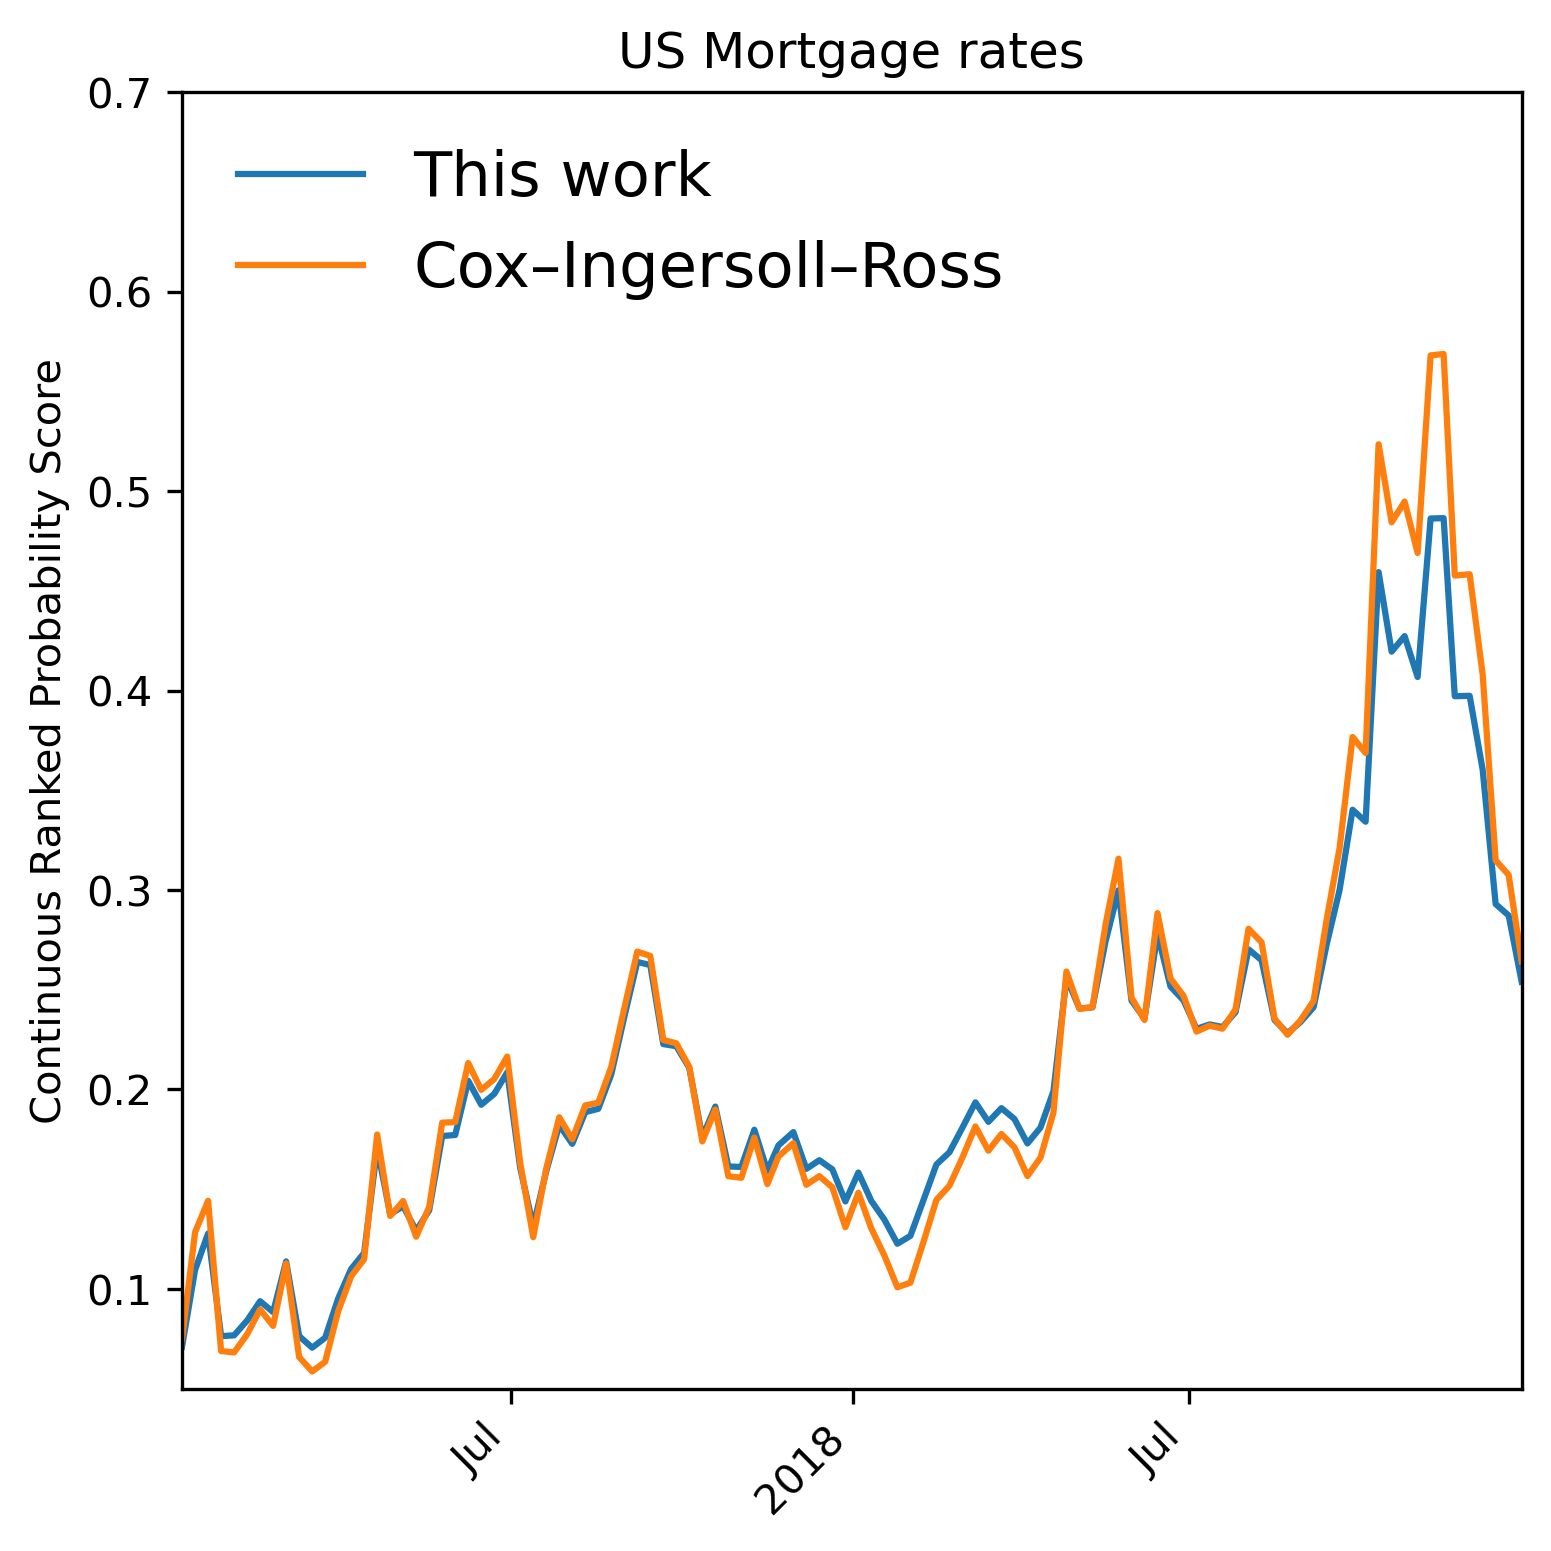

In [12]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=300)

ax.plot(df_test["DATE"].values,crpss, label="This work")
ax.plot(df_test["DATE"].values,report["CRPS"], label="Cox–Ingersoll–Ross")
#plt.plot(report_dli["CRPS"], label="dli")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show ticks for each day
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_xmargin(0)

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')
ax.set_ylim(0.05, 0.7)
ax.set_title('US Mortgage rates')
ax.set_ylabel('Continuous Ranked Probability Score')
legend = ax.legend(loc='upper left', fontsize=15, frameon = False)

fig.tight_layout(pad=0.1)

In [16]:
report["CRPS"].dump("data/mortgage/report.np")
np.array(crpss).dump("data/mortgage/crpss.np")
df_test["DATE"].values.dump("data/mortgage/x_axis.np")